In [1]:
""" (DRAGAN)
Deep Regret Analytic GAN

https://arxiv.org/pdf/1705.07215.pdf

This variant is similar to that of WGAN GP in that it imposes a gradient 

"""
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from itertools import product
from load_data import get_data

def to_var(x):
    """ function to automatically cudarize.. """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Load in data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

In [17]:
class Generator(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        """ Generator. Input is noise, output is a generated image. """
        super(Generator, self).__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation
        
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_dim, output_dim):
        """ Discriminator / Critic (not trained to classify). Input is an image (real or generated), output is P(generated). """
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.sigmoid(self.discriminate(activated))
        return discrimination
    
class DRAGAN(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim, output_dim = 1):
        """ Super class to contain both Discriminator (D) and Generator (G) """
        super(DRAGAN, self).__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim
            
class Trainer:
    def __init__(self, train_iter, val_iter, test_iter):
        """ Object to hold data iterators, train a GAN variant """
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
    
    def train(self, model, num_epochs, G_lr = 1e-4, D_lr = 1e-4, D_steps = 1):
        """ Train a Least Squares GAN
            Logs progress using G loss, D loss, visualizations of Generator output.

        Inputs:
            model: class, initialized DRAGAN module
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 1)
        Outputs:
            model: trained DRAGAN instance """
        G_optimizer = torch.optim.Adam(params=[p for p in model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in model.D.parameters() if p.requires_grad], lr=D_lr)
        
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Sigmoid cross entropy for first component of DRAGAN loss. The second part is 
        criterion = nn.BCELoss()
        
        for epoch in tqdm_notebook(range(1, num_epochs + 1)):
            model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                # TRAINING D: Train D for D_steps 
                for _ in range(D_steps):
                    
                    # Retrieve batch
                    images = self.process_batch(self.train_iter)

                    # Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator using samples from the generator
                    D_loss = self.train_D(model, images)
        
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Save relevant output for progress logging
                    D_step_loss.append(D_loss)
                    
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G. 
                G_optimizer.zero_grad()

                # Train the generator using predictions from D on the noise compared to true image labels
                # (learn to generate examples from noise that fool the discriminator)  
                G_loss = self.train_G(model, images)
              
                # Update parameters
                G_loss.backward()
                G_optimizer.step()

                # Save relevant output for progress logging
                G_losses.append(G_loss)
                
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses)))
            
            # Visualize generator progress
            fig = self.generate_images(model, epoch)
            plt.show()
            
        return model
    
    def train_D(self, model, images, LAMBDA = 10, K = 1):
        """ Run 1 step of training for discriminator
            
            G_noise = randomly generated noise, x'
            G_output = G(x'), generated images from noise
            DX_score = D(x), probability x is generated where x are real images
            DG_score = D(G(x')), probability G(x') is a generation where x' is noise
        """      
        
        # Generate labels for the real batch images (all 1, since they are real)
        X_labels = to_var(torch.ones(images.shape[0], 1)) 
        
        # Classify the real batch images, get the loss for these 
        DX_score = model.D(images)
        DX_loss = F.binary_cross_entropy(DX_score, X_labels)
        
        # Sample outputs from the generator
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_labels = to_var(torch.zeros(images.shape[0]))
        G_output = model.G(noise)
        
        # Classify the fake batch images, get the loss for these (labels being all 0, since they are fake)
        DG_score = model.D(G_output)
        DG_loss = F.binary_cross_entropy(DG_score.squeeze(), G_labels)
        
        # GRADIENT PENALTY STEPS:
        # Uniformly sample along one straight line per each batch entry. 
        delta = torch.rand(images.shape[0], 1).expand(images.size())

        # Generate images from the noise, ensure unit 
        G_interpolation = to_var(delta * images.data + (1 - delta) * (images.data + 0.5 * images.data.std() * torch.rand(images.size())))
        G_interpolation.requires_grad = True

        D_interpolation = model.D(G_interpolation)

        # Compute the gradients of D with respect to the noise generated input
        gradients = torch.autograd.grad(outputs = D_interpolation, 
                            inputs = G_interpolation,
                            grad_outputs = torch.ones(D_interpolation.size()), # TODO: cuda
                            only_inputs = True,
                            create_graph = True,
                            retain_graph = True,)[0]

        # Full gradient penalty
        grad_penalty = LAMBDA * torch.mean((gradients.norm(2, dim = 1) - K) **2)
        
        # Put it all together
        D_loss = DX_loss + DG_loss + grad_penalty
        
        return D_loss
    
    def train_G(self, model, images):
        """ Run 1 step of training for generator
        
            G_noise = randomly generated noise, x'
            G_output = G(x')
            DG_score = D(G(x'))
        """
        # Generate labels for the generator batch images (all 0, since they are fake)
        G_labels = to_var(torch.ones(images.shape[0], 1)) 
        
        # Get noise, classify it using G, then classify the output of G using D.
        G_noise = self.compute_noise(images.shape[0], model.z_dim) # x'
        G_output = model.G(G_noise) # G(x')
        DG_score = model.D(G_output) # D(G(x'))
        
        # Compute standard G loss
        G_loss = F.binary_cross_entropy(DG_score, G_labels)
        
        return G_loss
    
    def compute_noise(self, batch_size, image_size):
        """ Compute random noise for the generator to learn to make images from """
        return to_var(torch.randn(batch_size, image_size))
    
    def generate_images(self, model, epoch, num_outputs = 25, save = True):
        """ Visualize progress of generator learning """
        noise = self.compute_noise(num_outputs, model.z_dim)
        images = model.G(noise)
        images = images.view(images.shape[0], 28, 28)
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        if save:
            if not os.path.exists('../viz/ls-gan/'):
                os.makedirs('../viz/ls-gan/')
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), '../viz/ls-gan/reconst_%d.png' %(epoch), nrow = 5)
        return fig
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_var(images.view(images.shape[0], -1))
        return images

    def save_model(self, model, savepath):
        """ Save model state dictionary """
        torch.save(model.state_dict(), savepath + 'saved_gan.pth')
    
    def load_model(self, loadpath,  model = None):
        """ Load state dictionary into model. If model not specified, instantiate it """
        if not model:
            model = DRAGAN()
        state = torch.load(loadpath)
        model.load_state_dict(state)
        return model


Epoch[1/100], G Loss: 1.1874, D Loss: 6.4050


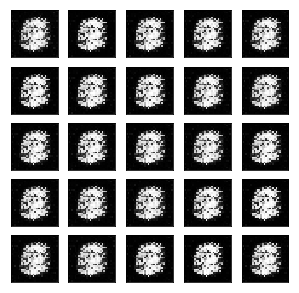

Epoch[2/100], G Loss: 0.7231, D Loss: 5.8674


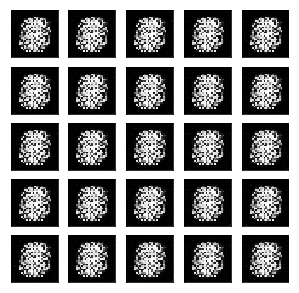

Epoch[3/100], G Loss: 0.6867, D Loss: 7.6726


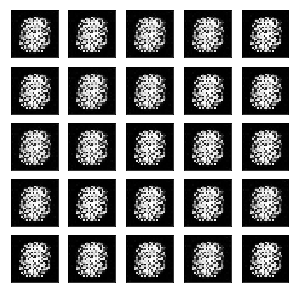

Epoch[4/100], G Loss: 0.7142, D Loss: 7.7244


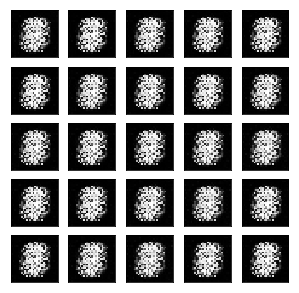

Epoch[5/100], G Loss: 0.7353, D Loss: 7.7195


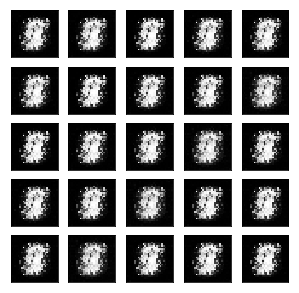

Epoch[6/100], G Loss: 0.7588, D Loss: 7.5773


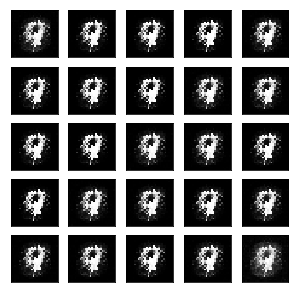

Epoch[7/100], G Loss: 0.7787, D Loss: 7.4715


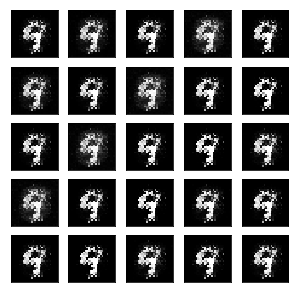

Epoch[8/100], G Loss: 0.7844, D Loss: 7.3108


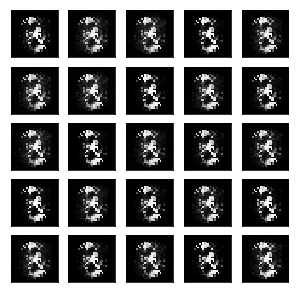

Epoch[9/100], G Loss: 0.7678, D Loss: 7.1085


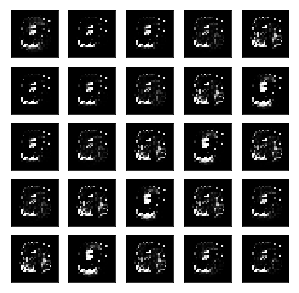

Epoch[10/100], G Loss: 0.7645, D Loss: 6.8878


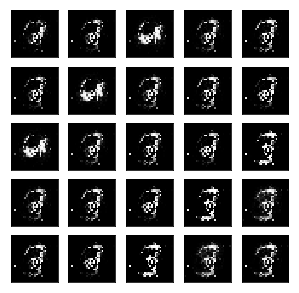

Epoch[11/100], G Loss: 0.7742, D Loss: 6.9308


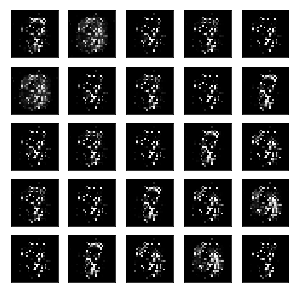

Epoch[12/100], G Loss: 0.7915, D Loss: 6.5174


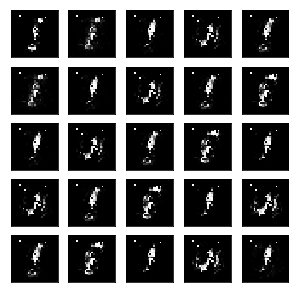

In [ ]:
model = DRAGAN(image_size = 784, hidden_dim = 512, z_dim = 256)
if torch.cuda.is_available():
    model = model.cuda()
trainer = Trainer(train_iter, val_iter, test_iter)
model = trainer.train(model = model, num_epochs = 100, G_lr = 1e-3, D_lr = 1e-4, D_steps = 1)